#Set Up Environment

Import all the important packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import skew, kurtosis
import statsmodels.api as sm
from prettytable import PrettyTable
import os
import sys
from dotenv import load_dotenv

# Specify the custom .env file
load_dotenv(dotenv_path='environment_variables.env')

True

Import self written classes

In [2]:
# Add the src/data directory to the system path
sys.path.append('../src/data')

parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)
parent_dir

# import functions capable of handling specific needs related to financial markets data
from src.models.financial_data_processor import FinancialDataProcessor
data_processor = FinancialDataProcessor()

from src.models.momentum_strategy import MomentumStrategy
momentum = MomentumStrategy()

Set the env variable.

In [3]:
ProjectName = 'SPX-Industry-Momentum'

os.environ['RESEARCH_PATH']  = os.environ.get('PROJECT_ROOT')
research_path = os.environ.get('RESEARCH_PATH')
if research_path:
    path = os.path.join(research_path, ProjectName)
    print(path)
    file_path = os.path.join(path, 'data', 'raw')
    print(file_path)
else:
    print("RESEARCH_PATH environment variable is not set.")

/Users/marcobischoff/Library/Mobile Documents/3L68KQB4HG~com~readdle~CommonDocuments/Documents/Banking & Finance/Digital Tools for Finance/SPX-Industry-Momentum
/Users/marcobischoff/Library/Mobile Documents/3L68KQB4HG~com~readdle~CommonDocuments/Documents/Banking & Finance/Digital Tools for Finance/SPX-Industry-Momentum/data/raw


# Define all the functions

In [4]:
def create_colorheatmap(weights):
    """
    Creates and displays a color-blind friendly heatmap.

    Parameters:
    - weights (2D array-like): The data to be visualized in the heatmap.
    """
    plt.figure(figsize=(10, 6))
    # Using the 'cividis' colormap which is designed to be colorblind-friendly
    sns.heatmap(weights, cmap='cividis', cbar=True)
    plt.title("Heatmap of weights over months")
    plt.xlabel("Assets")
    plt.ylabel("Months")
    plt.show()

In [5]:
def plot_strategies_with_benchmark(dates, strategy_returns_list, benchmark_returns, labels, start_month):
    """
    Plots strategy returns (single or multiple) along with a benchmark return in a color-blind friendly way.

    Parameters:
    - dates (array-like): Dates for the x-axis.
    - strategy_returns_list (array-like or list of array-like): Total returns of one or multiple strategies.
    - benchmark_returns (array-like): Total returns of the benchmark.
    - labels (list of str): List of labels for the strategy return series.
    - start_month (int): The starting index for the plot.
    """
    # Check if strategy_returns_list is a single series or a list of series
    if isinstance(strategy_returns_list, np.ndarray):
        strategy_returns_list = [strategy_returns_list]  # Convert to a list for consistency
        labels = [labels]  # Assume labels is a single string and convert to a list

    if len(strategy_returns_list) > 5:
        raise ValueError("Cannot plot more than 5 strategy return series.")

    # Define a list of color-blind friendly colors for strategies
    strategy_colors = ['seagreen', 'darkorange', 'purple', 'grey', 'brown']

    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot each strategy return series
    for i, returns in enumerate(strategy_returns_list):
        cumulative_returns = np.cumprod(1 + returns[start_month:]) - 1
        ax.plot(dates[start_month:], cumulative_returns, label=labels[i], color=strategy_colors[i], linestyle='-')

    # Plot the benchmark return series
    cumulative_benchmark_returns = np.cumprod(1 + benchmark_returns[start_month:].squeeze()) - 1
    ax.plot(dates[start_month:], cumulative_benchmark_returns, label='Benchmark', color='darkblue', linestyle='--')

    # Add labels, title, and legend
    ax.set_xlabel('Date')
    ax.set_ylabel('Cumulative Returns')
    ax.set_title('Strategies vs. Benchmark Cumulative Returns')
    ax.legend()

    # Format the date for monthly data
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    # Display the plot
    plt.tight_layout()
    plt.show()
    


In [6]:
def summarizePerformance(xsReturns, Rf, factorXsReturns, annualizationFactor, startM, txt):

    # Shorten Series
    xsReturns = xsReturns[startM:]
    factorXsReturns = factorXsReturns[startM:]
    Rf = Rf[startM:]
    if len(xsReturns.shape) == 1:
      nPeriods = len(xsReturns)
      nAssets = 1
      xsReturns = xsReturns[:, np.newaxis]  # Convert to 2D for consistency
    else:
      nPeriods, nAssets = xsReturns.shape
    totalReturns = xsReturns + np.outer(Rf, np.ones(nAssets))

    # Compute the terminal value of the portfolios to get the geometric mean return per period
    FinalPfValRf = np.prod(1 + Rf)
    FinalPfValTotalRet = np.prod(1 + totalReturns, axis=0)
    GeomAvgRf = 100 * (FinalPfValRf ** (annualizationFactor / nPeriods) - 1)
    GeomAvgTotalReturn = 100 * (FinalPfValTotalRet ** (annualizationFactor / nPeriods) - 1)
    GeomAvgXsReturn = GeomAvgTotalReturn - GeomAvgRf

    # Regress returns on benchmark to get alpha and factor exposures
    X = np.column_stack((np.ones(nPeriods), factorXsReturns))
    betas, _, _, _ = np.linalg.lstsq(X, xsReturns, rcond=None)
    betas = betas[1:]

    bmRet = factorXsReturns.dot(betas) + np.outer(Rf, np.ones(nAssets))
    FinalPfValBm = np.prod(1 + bmRet, axis=0)
    GeomAvgBmReturn = 100 * (FinalPfValBm ** (annualizationFactor / nPeriods) - 1)
    alphaGeometric = GeomAvgTotalReturn - GeomAvgBmReturn

    alpha_monthly_timeseries = totalReturns - factorXsReturns.dot(np.ones((nAssets, nAssets)))
    GeoAlphaDeannualized = (1 + (alphaGeometric / 100)) ** (1 / annualizationFactor) - 1
    std_alpha_monthly = np.std(alpha_monthly_timeseries, axis=0)
    SE_alpha = std_alpha_monthly / np.sqrt(nPeriods)
    tvaluealpha = GeoAlphaDeannualized / SE_alpha

    # Rescale the returns to be in percentage points
    xsReturns = 100 * xsReturns
    totalReturns = 100 * totalReturns

    # Compute first three autocorrelations
    AC1 = np.diag(np.corrcoef(xsReturns[:-1].T, xsReturns[1:].T)[nAssets:2*nAssets, :nAssets])
    AC2 = np.diag(np.corrcoef(xsReturns[:-2].T, xsReturns[2:].T)[nAssets:2*nAssets, :nAssets])
    AC3 = np.diag(np.corrcoef(xsReturns[:-3].T, xsReturns[3:].T)[nAssets:2*nAssets, :nAssets])

    # Report the statistics
    ArithmAvgTotalReturn = annualizationFactor * np.mean(totalReturns, axis=0)
    ArithmAvgXsReturn = annualizationFactor * np.mean(xsReturns, axis=0)
    StdXsReturns = np.sqrt(annualizationFactor) * np.std(xsReturns, axis=0)
    SharpeArithmetic = ArithmAvgXsReturn / StdXsReturns
    SharpeGeometric = GeomAvgXsReturn / StdXsReturns
    MinXsReturn = np.min(xsReturns, axis=0)
    MaxXsReturn = np.max(xsReturns, axis=0)
    SkewXsReturn = skew(xsReturns, axis=0)
    KurtXsReturn = kurtosis(xsReturns, axis=0)
    alphaArithmetic = annualizationFactor * 100 * betas[0]

    # Create table
    x = PrettyTable()
    x.field_names = ["Statistic", "Value"]

    x.add_row(["ArithmAvgTotalReturn", ArithmAvgTotalReturn])
    x.add_row(["ArithmAvgXsReturn", ArithmAvgXsReturn])
    x.add_row(["StdXsReturns", StdXsReturns])
    x.add_row(["SharpeArithmetic", SharpeArithmetic])
    x.add_row(["SharpeGeometric", SharpeGeometric])
    x.add_row(["MinXsReturn", MinXsReturn])
    x.add_row(["MaxXsReturn", MaxXsReturn])
    x.add_row(["SkewXsReturn", SkewXsReturn])
    x.add_row(["KurtXsReturn", KurtXsReturn])
    x.add_row(["alphaArithmetic", alphaArithmetic])

    return (ArithmAvgTotalReturn, ArithmAvgXsReturn, StdXsReturns, SharpeArithmetic, MinXsReturn, MaxXsReturn, SkewXsReturn, KurtXsReturn, alphaArithmetic, tvaluealpha, betas, x)

Import the Data

In [7]:
# Import the Function to load the Data
from load_data import load_data

# Define which Excel to Load
Excel_file_name = 'Bloomberg_Download.xlsx'

# Load the Data
dates_dateformat, SPXT, Sectors, Rf, Industry_Groups = load_data(file_path, Excel_file_name)

Process the Data

In [ ]:
# Import the Function to process the Data
from process_data import process_data

# Process the Data
dates_datetime, numericDate_d, firstDayList, lastDayList, dates4plot, Sectors_returns_d, Industry_Groups_returns_d, returns_SPX, returns_SPX_monthly, rf_d_unadjusted, rf_d, rf_d_monthly = process_data(dates_dateformat, Sectors, Industry_Groups, SPXT, Rf)

#Modify and process the data

In [8]:
# Define meta variables for the analysis
trx_cost = 0.001;
nLong = 3;
nShort = 0;
startMonth = 101;
tradingLag = 0;
lookback_period_start = 9
lookback_period_end = 1
holding_period = 3
trading_lag = 0
myLineWidth = 2
RobustnessCheckColor = 'blue'

In [9]:
xsReturns_TC, totalReturns_TC, weights = momentum.backtest_momentum(returns_m, rf_m, lookback_period_start, lookback_period_end, holding_period, startMonth, nLong, nShort, trx_cost)

/Users/marcobischoff/Library/Mobile Documents/3L68KQB4HG~com~readdle~CommonDocuments/Documents/Banking & Finance/Digital Tools for Finance/SPX-Industry-Momentum/src/models/momentum_strategy.py:171: RuntimeWarning: divide by zero encountered in divide
  weights_short[month, :] /= total_short_weight
/Users/marcobischoff/Library/Mobile Documents/3L68KQB4HG~com~readdle~CommonDocuments/Documents/Banking & Finance/Digital Tools for Finance/SPX-Industry-Momentum/src/models/momentum_strategy.py:171: RuntimeWarning: invalid value encountered in divide
  weights_short[month, :] /= total_short_weight


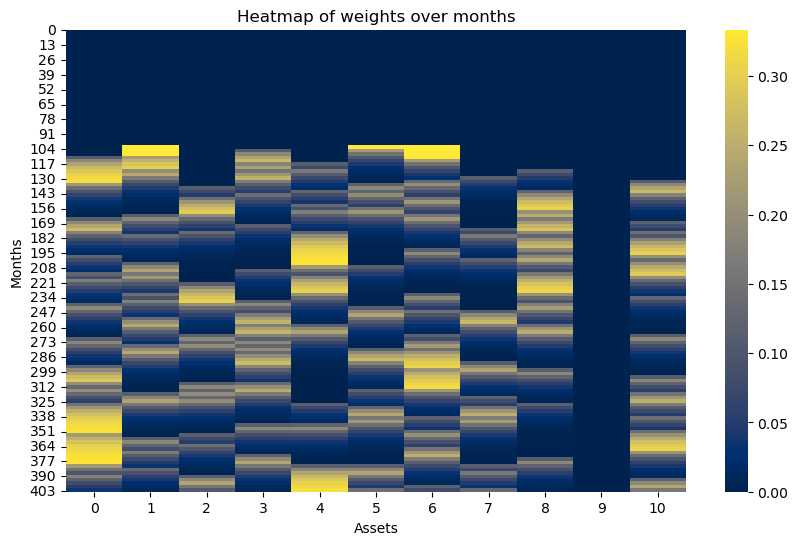

In [10]:
create_colorheatmap(weights)

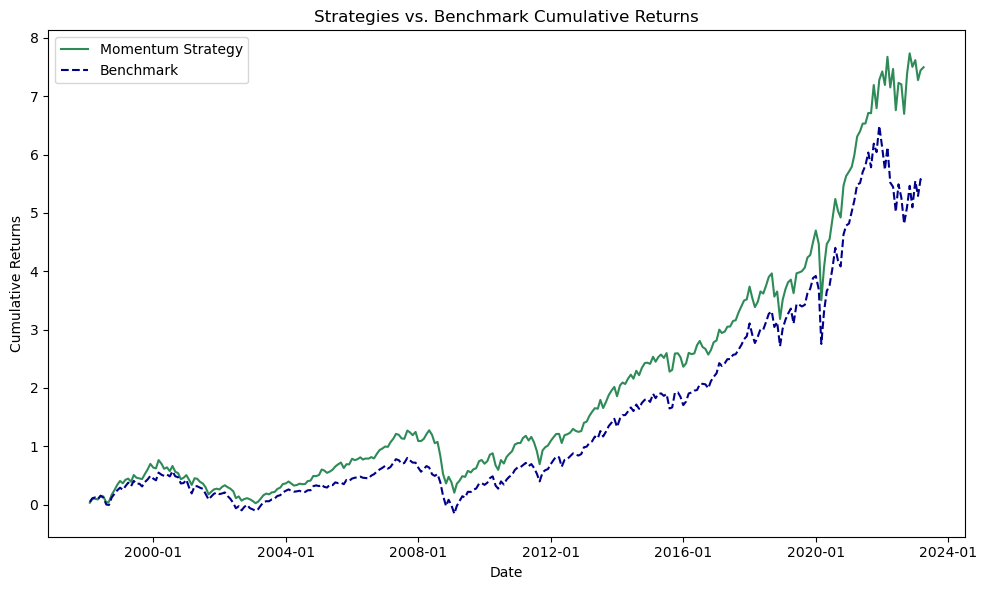

In [11]:
plot_strategies_with_benchmark(dates4plot, totalReturns_TC, returns_SPX_monthly, 'Momentum Strategy', startMonth)

In [12]:
ArithmAvgTotalReturn, ArithmAvgXsReturn, StdXsReturns, SharpeArithmetic, MinXsReturn, MaxXsReturn, SkewXsReturn, KurtXsReturn, alphaArithmetic, tvaluealpha, betas, summary_table = summarizePerformance(xsReturns_TC, rf_d_monthly, returns_SPX_monthly, 12, startMonth, "Momentum")
print(summary_table)

+----------------------+----------------+
|      Statistic       |     Value      |
+----------------------+----------------+
| ArithmAvgTotalReturn |  [9.78478786]  |
|  ArithmAvgXsReturn   |  [7.92700959]  |
|     StdXsReturns     | [15.90519145]  |
|   SharpeArithmetic   |  [0.49839133]  |
|   SharpeGeometric    |  [0.43833249]  |
|     MinXsReturn      | [-17.65697321] |
|     MaxXsReturn      | [13.92357367]  |
|     SkewXsReturn     | [-0.62847198]  |
|     KurtXsReturn     |  [1.50404537]  |
|   alphaArithmetic    | [1063.5586891] |
+----------------------+----------------+


#Robustness Checks

/Users/marcobischoff/Library/Mobile Documents/3L68KQB4HG~com~readdle~CommonDocuments/Documents/Banking & Finance/Digital Tools for Finance/SPX-Industry-Momentum/src/models/momentum_strategy.py:171: RuntimeWarning: divide by zero encountered in divide
  weights_short[month, :] /= total_short_weight
/Users/marcobischoff/Library/Mobile Documents/3L68KQB4HG~com~readdle~CommonDocuments/Documents/Banking & Finance/Digital Tools for Finance/SPX-Industry-Momentum/src/models/momentum_strategy.py:171: RuntimeWarning: invalid value encountered in divide
  weights_short[month, :] /= total_short_weight


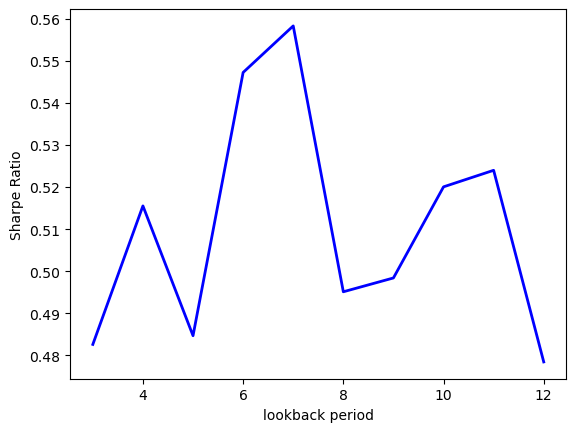

In [13]:
# Define parameters and initialize empty lists or arrays
lookback_period_loop = range(3, 13)
sharpRatio_mom_lb_loop = [0] * len(lookback_period_loop)

# Iterate over the lookback periods
for i, lb_period in enumerate(lookback_period_loop):
    xsReturns_mom_TC_lb, _, _ = momentum.backtest_momentum(returns_m, rf_m, lb_period, lookback_period_end, holding_period, startMonth, nLong, nShort, trx_cost)
    _, _, _, sharpRatio_mom, _, _, _, _, _, _, _, _ = summarizePerformance(xsReturns_mom_TC_lb, rf_d_monthly, returns_SPX_monthly, 12, startMonth, "Momentum")

    sharpRatio_mom_lb_loop[i] = sharpRatio_mom

# Plot the results
plt.figure()
plt.plot(lookback_period_loop, sharpRatio_mom_lb_loop, linewidth=myLineWidth, color=RobustnessCheckColor)
plt.xlabel("lookback period")
plt.ylabel("Sharpe Ratio")
plt.show()

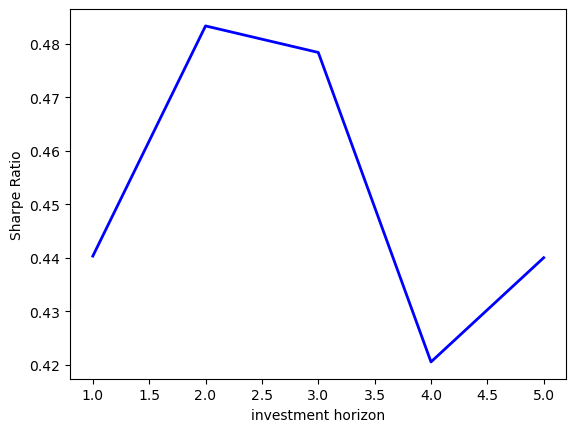

In [14]:
# Define parameters and initialize empty lists or arrays
investment_horizon_loop = range(1, 6)
sharpRatio_investment_horizon_loop = [0] * len(investment_horizon_loop)

# Iterate over the investment horizons
for i, inv_horizon in enumerate(investment_horizon_loop):
    # Based on your MATLAB code, lookback period start is fixed at 9, lookback period end is fixed at 1
    xsReturns_mom_TC_IH, _, _ = momentum.backtest_momentum(returns_m, rf_m, lb_period, lookback_period_end, inv_horizon, startMonth, nLong, nShort, trx_cost)
    _, _, _, sharpRatio_mom, _, _, _, _, _, _, _, _= summarizePerformance(xsReturns_mom_TC_IH, rf_d_monthly, returns_SPX_monthly, 12, startMonth, 'mom_inv_horizon')

    sharpRatio_investment_horizon_loop[i] = sharpRatio_mom

# Plot the results
plt.figure()
plt.plot(investment_horizon_loop, sharpRatio_investment_horizon_loop, linewidth=myLineWidth, color=RobustnessCheckColor)
plt.xlabel("investment horizon")
plt.ylabel("Sharpe Ratio")
plt.show()

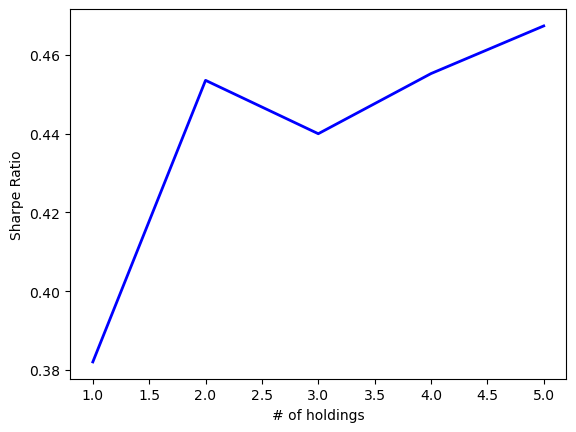

In [15]:
# Define parameters and initialize empty lists or arrays
holdings_loop = range(1, 6)
sharpRatio_holdings_loop = [0] * len(holdings_loop)

# Iterate over the investment horizons
for i, holdings in enumerate(holdings_loop):
    # Based on your MATLAB code, lookback period start is fixed at 9, lookback period end is fixed at 1
    xsReturns_mom_TC_holdings, _, _ = momentum.backtest_momentum(returns_m, rf_m, lb_period, lookback_period_end, inv_horizon, startMonth, holdings, nShort, trx_cost)
    _, _, _, sharpRatio_mom, _, _, _, _, _, _, _, _ = summarizePerformance(xsReturns_mom_TC_holdings, rf_d_monthly, returns_SPX_monthly, 12, startMonth, 'mom_inv_horizon')

    sharpRatio_holdings_loop[i] = sharpRatio_mom

# Plot the results
plt.figure()
plt.plot(holdings_loop, sharpRatio_holdings_loop, linewidth=myLineWidth, color=RobustnessCheckColor)
plt.xlabel("# of holdings")
plt.ylabel("Sharpe Ratio")
plt.show()

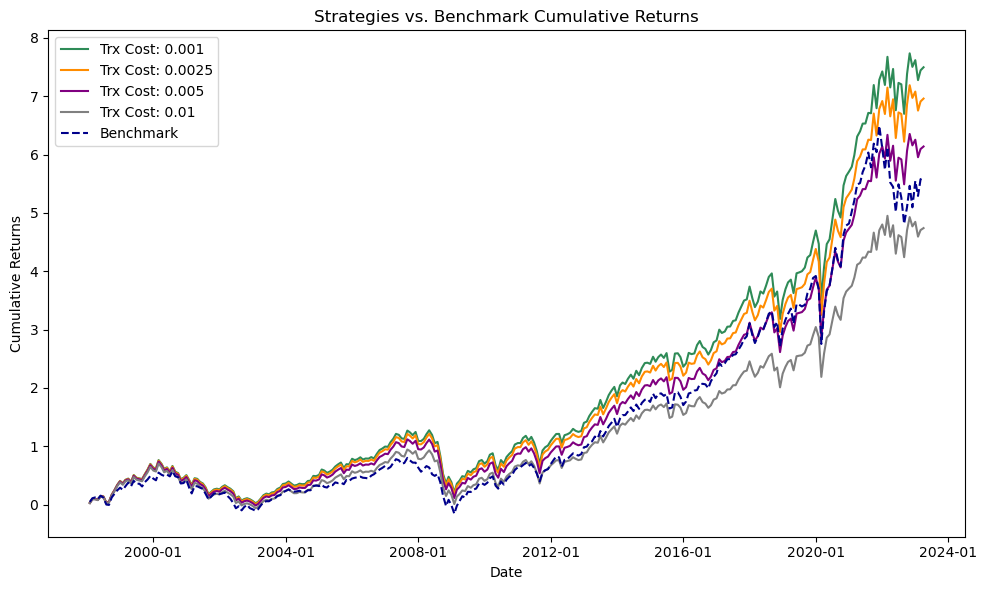

In [16]:
tx_costs = [0.001, 0.0025, 0.005, 0.01]
total_returns_tx_costs = []
labels = []

for trx_cost in tx_costs:
    _, totalReturns_TC, _ = momentum.backtest_momentum(
        returns_m, rf_m, lookback_period_start, lookback_period_end,
        holding_period, startMonth, nLong, nShort, trx_cost
    )
    # Storing the total returns in a list
    total_returns_tx_costs.append(totalReturns_TC)
    # Creating corresponding labels
    labels.append(f'Trx Cost: {trx_cost}')

plot_strategies_with_benchmark(dates4plot, total_returns_tx_costs, returns_SPX_monthly, labels, startMonth)